# Resnet on RSICB dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

# Path to your zip file
zip_path = '/content/drive/MyDrive/GroupO_DataSet.zip'
extract_dir = 'GroupO_DataSet'  # Folder where all extracted folders will be stored

# Create a main extraction directory
os.makedirs(extract_dir, exist_ok=True)

# Extract each main folder separately
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        # Extract files while preserving folder structure
        zip_ref.extract(file, extract_dir)

print("Extraction complete. Check the folder:", extract_dir)


Extraction complete. Check the folder: GroupO_DataSet


In [17]:
# Importing necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [20]:
dataset = torchvision.datasets.ImageFolder(root='/content/GroupO_DataSet/RSI-CB/', transform=data_transforms)

In [21]:
train_size = int(0.7 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

In [22]:
batch_size = 64
learning_rate = 0.001
num_epochs = 40

# Print the configuration
print(f"Training with batch size: {batch_size}, learning rate: {learning_rate}, and epochs: {num_epochs}")


Training with batch size: 64, learning rate: 0.001, and epochs: 40


In [23]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,5)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [26]:
loss_during_epoch = []
accuracy_during_epoch = []


In [27]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output, dim=1)

        self.model.zero_grad()
        output[:, target_class].backward(retain_graph=True)

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)
        return cam

def visualize_gradcam(cam, original_image, alpha=0.5):
    cam = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(original_image / 255)
    overlay = overlay / np.max(overlay)
    return np.uint8(255 * overlay)


Epoch 1, Loss: 0.574318410836773, Accuracy: 79.14%, Validation Loss: 0.43942222134633496, Validation Accuracy: 83.18%, Running time: 116.97485542297363


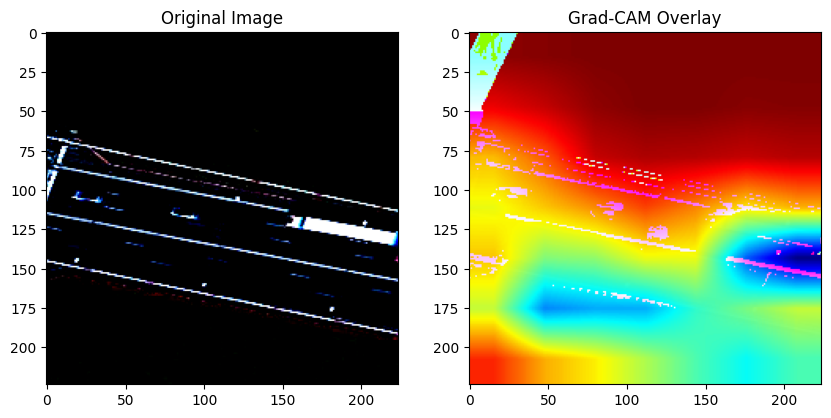

Epoch 2, Loss: 0.34701682691708274, Accuracy: 87.44%, Validation Loss: 0.29473567167014786, Validation Accuracy: 88.64%, Running time: 104.38979625701904


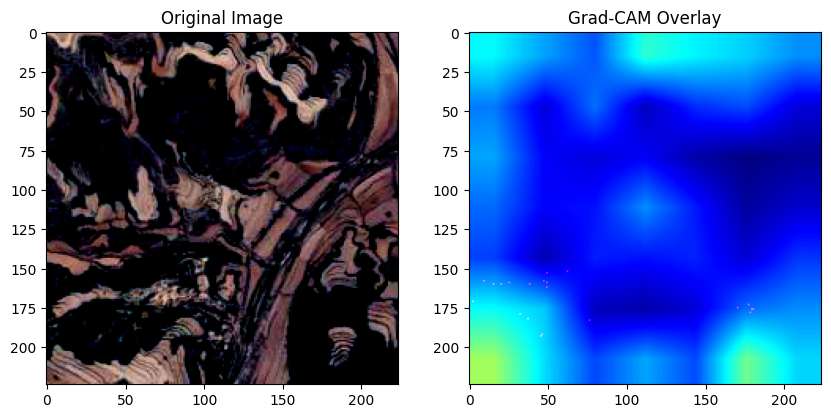

Epoch 3, Loss: 0.28514075838835723, Accuracy: 89.94%, Validation Loss: 0.26444041977326077, Validation Accuracy: 90.88%, Running time: 103.85012197494507


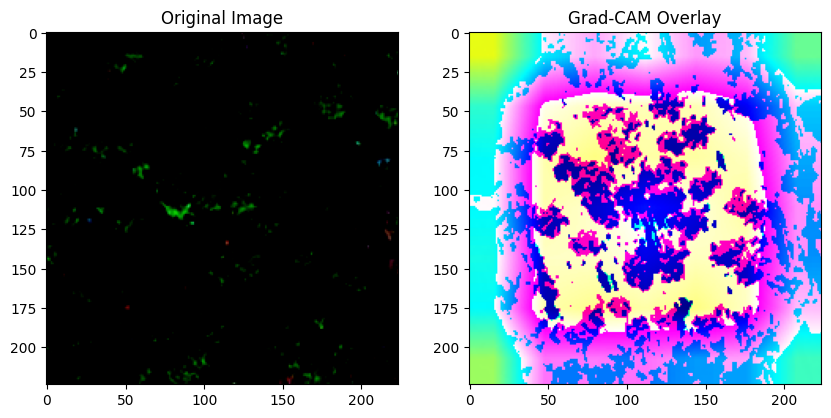

Epoch 4, Loss: 0.2518683229109426, Accuracy: 91.14%, Validation Loss: 0.15412522050918956, Validation Accuracy: 94.61%, Running time: 104.49384260177612


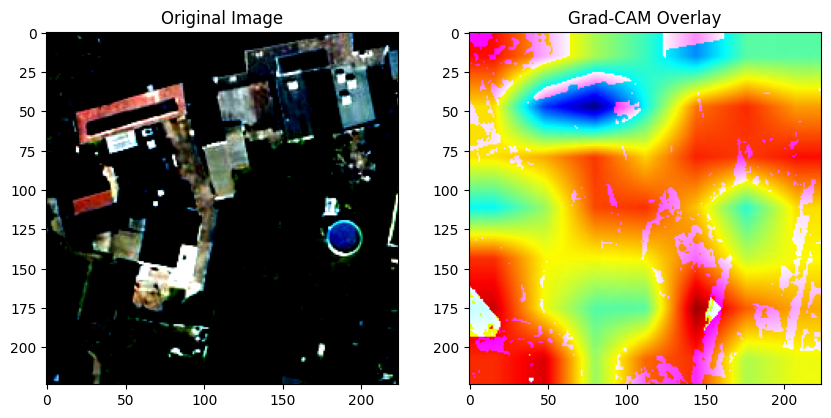

Epoch 5, Loss: 0.21096837468993612, Accuracy: 92.72%, Validation Loss: 0.34373615512793715, Validation Accuracy: 88.22%, Running time: 104.927894115448


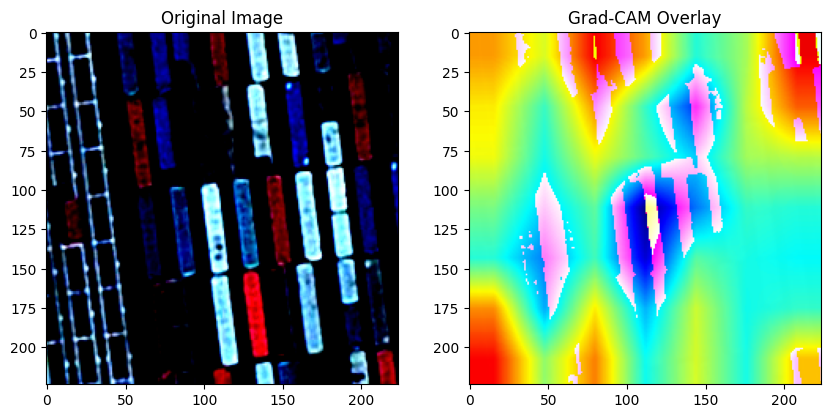

Epoch 6, Loss: 0.18826319748189027, Accuracy: 93.48%, Validation Loss: 0.16220179888786693, Validation Accuracy: 94.46%, Running time: 104.5079734325409


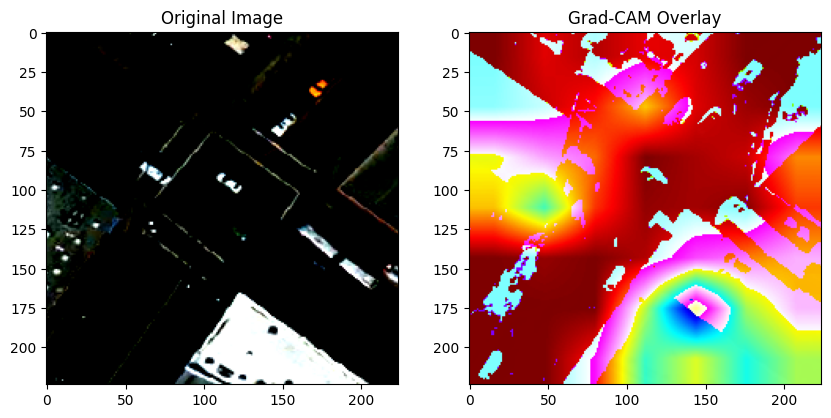

Epoch 7, Loss: 0.16508811481651806, Accuracy: 94.49%, Validation Loss: 0.14931175050636133, Validation Accuracy: 94.23%, Running time: 106.66144108772278


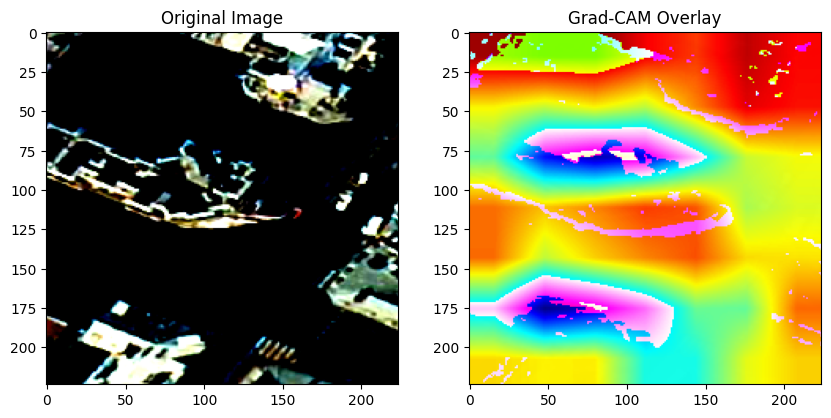

Epoch 8, Loss: 0.1689714676099809, Accuracy: 94.10%, Validation Loss: 0.18366638424270082, Validation Accuracy: 93.51%, Running time: 104.31169438362122


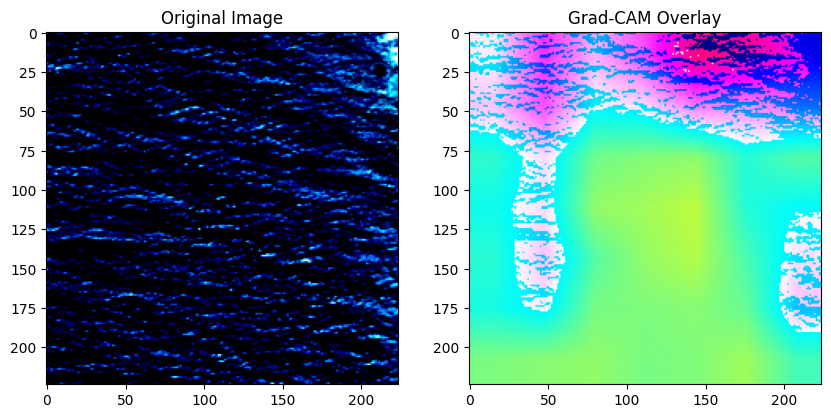

Epoch 9, Loss: 0.13289472825615567, Accuracy: 95.51%, Validation Loss: 0.19168950323805664, Validation Accuracy: 93.66%, Running time: 105.8532075881958


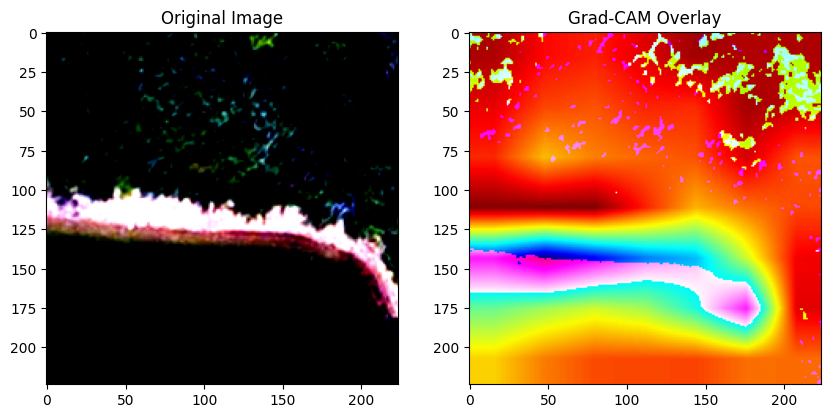

Epoch 10, Loss: 0.14600559015197928, Accuracy: 95.08%, Validation Loss: 0.34276873234546545, Validation Accuracy: 87.43%, Running time: 105.42396926879883


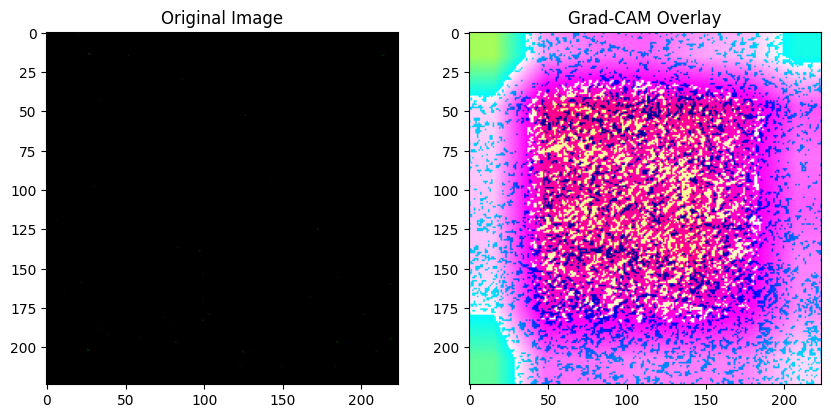

Epoch 11, Loss: 0.18247437857704246, Accuracy: 93.81%, Validation Loss: 1.0769027575398937, Validation Accuracy: 82.82%, Running time: 104.73490381240845


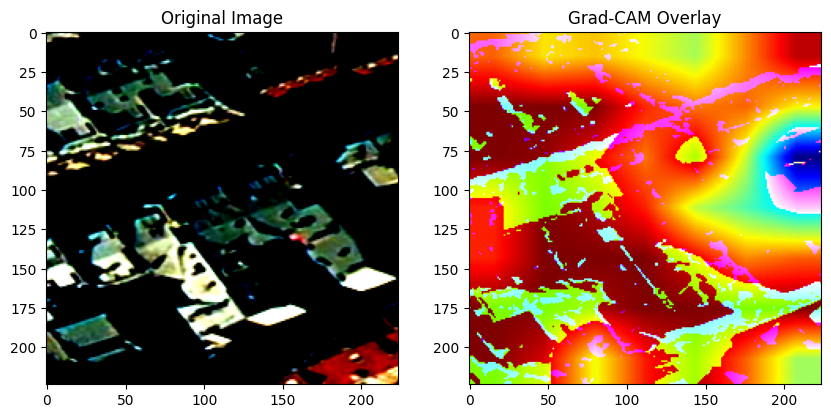

Epoch 12, Loss: 0.19316892504079258, Accuracy: 93.49%, Validation Loss: 0.14656608850892747, Validation Accuracy: 94.42%, Running time: 105.54939270019531


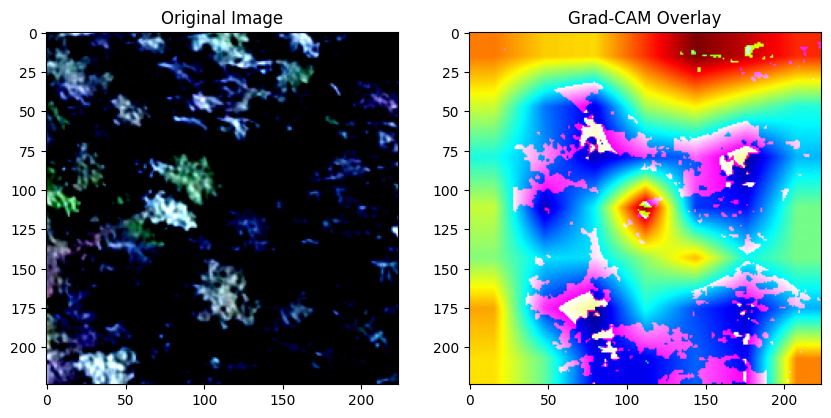

Epoch 13, Loss: 0.11793321569438105, Accuracy: 95.94%, Validation Loss: 0.13706474516992317, Validation Accuracy: 95.39%, Running time: 106.30148601531982


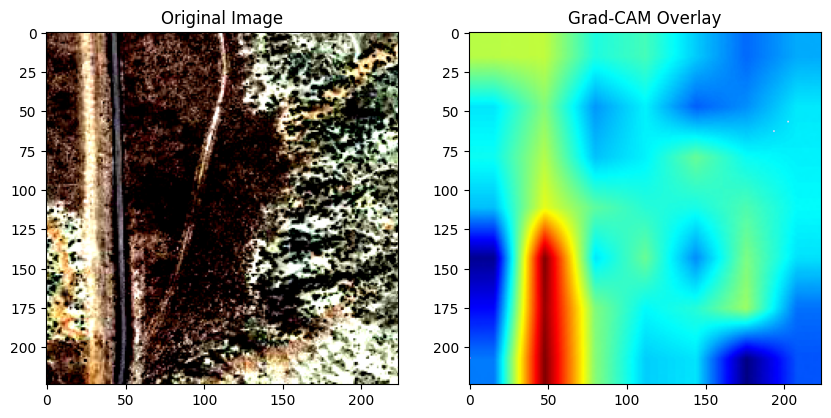

Epoch 14, Loss: 0.10090142317938727, Accuracy: 96.48%, Validation Loss: 0.14036022044831153, Validation Accuracy: 95.06%, Running time: 104.5825834274292


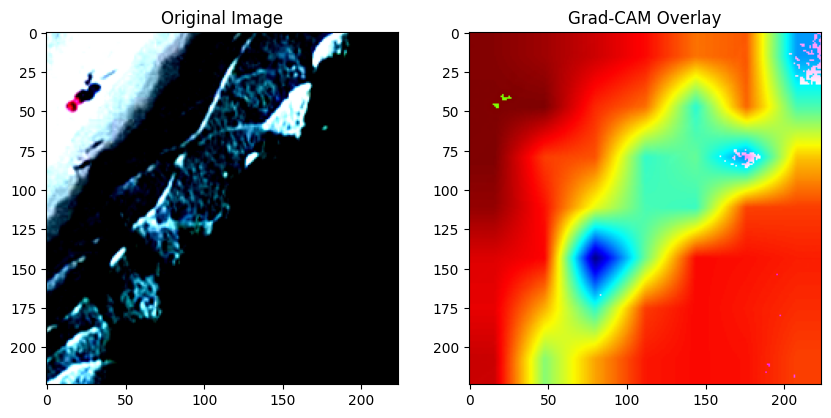

Epoch 15, Loss: 0.09303981932968676, Accuracy: 96.86%, Validation Loss: 0.10529669559786492, Validation Accuracy: 96.39%, Running time: 106.96510601043701


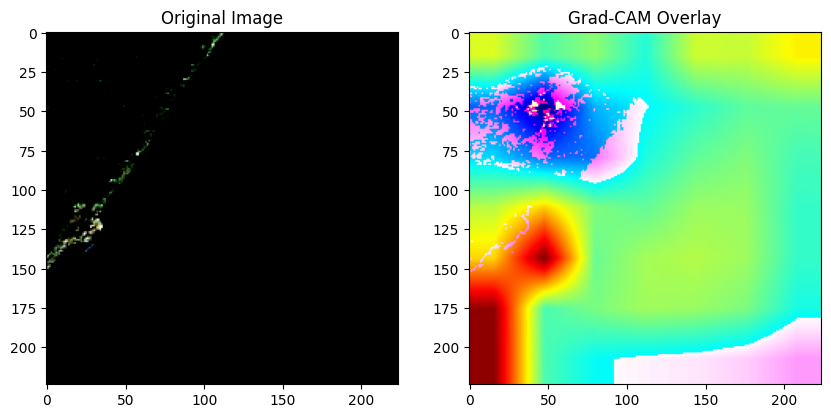

Epoch 16, Loss: 0.08197032633636679, Accuracy: 97.20%, Validation Loss: 0.07066430323616121, Validation Accuracy: 97.62%, Running time: 104.58255934715271


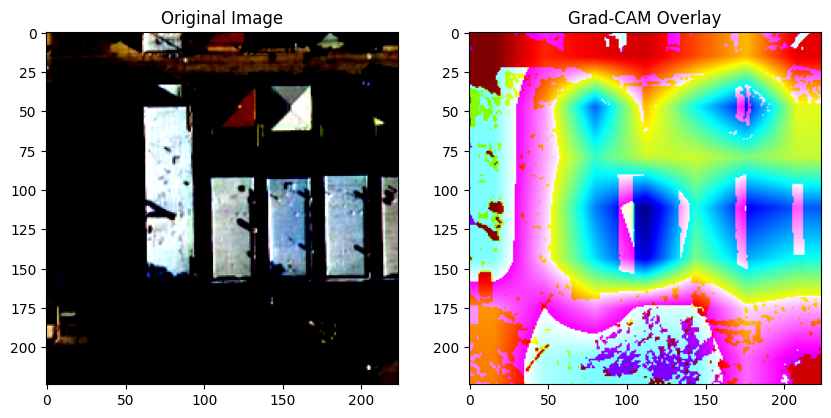

Epoch 17, Loss: 0.0779971690844438, Accuracy: 97.22%, Validation Loss: 0.08371646106807572, Validation Accuracy: 97.01%, Running time: 104.92852520942688


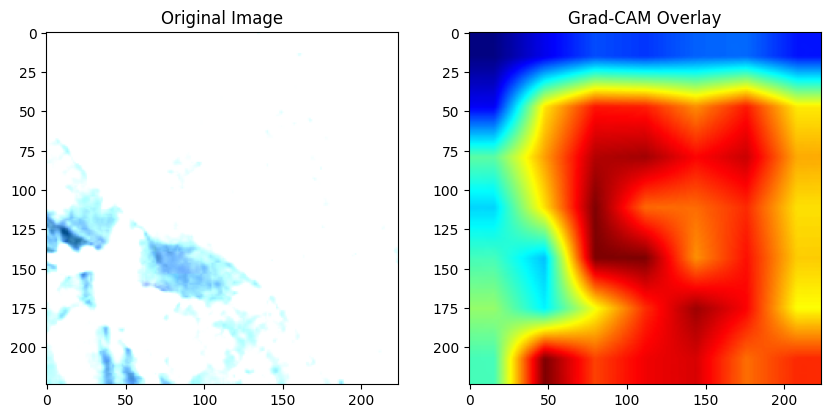

Epoch 18, Loss: 0.06962199386176995, Accuracy: 97.60%, Validation Loss: 0.07480799930283066, Validation Accuracy: 97.51%, Running time: 105.84032917022705


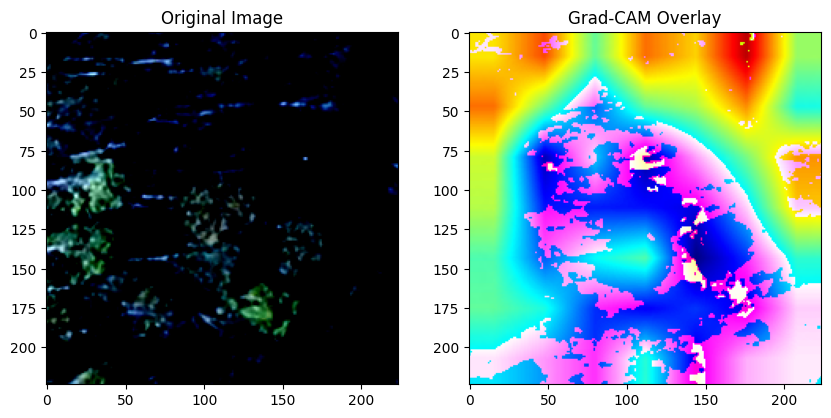

Epoch 19, Loss: 0.05732715082278241, Accuracy: 98.09%, Validation Loss: 0.12435733303992134, Validation Accuracy: 95.44%, Running time: 104.36640405654907


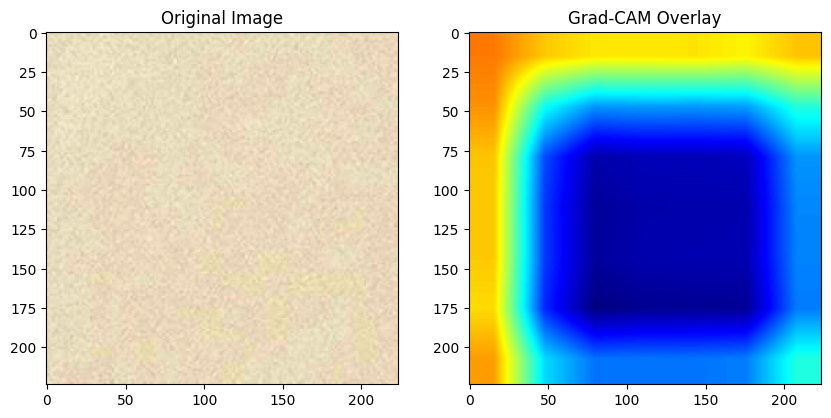

Epoch 20, Loss: 0.06911407217274529, Accuracy: 97.69%, Validation Loss: 0.12684465896789776, Validation Accuracy: 95.96%, Running time: 106.34388542175293


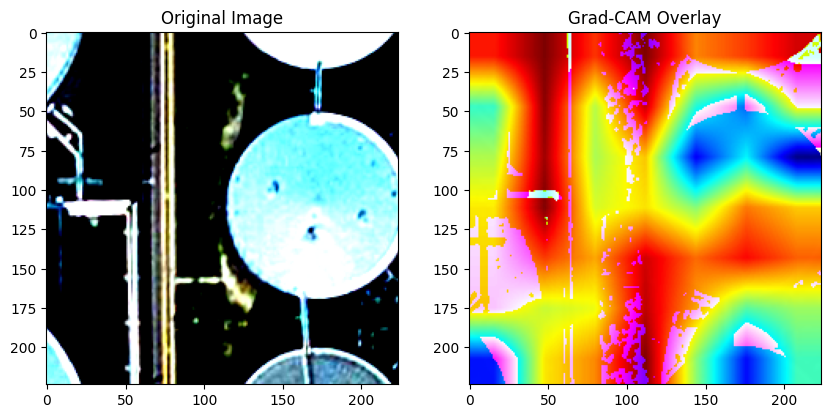

Epoch 21, Loss: 0.05417282149085807, Accuracy: 98.01%, Validation Loss: 0.13381065918612434, Validation Accuracy: 96.15%, Running time: 104.3768618106842


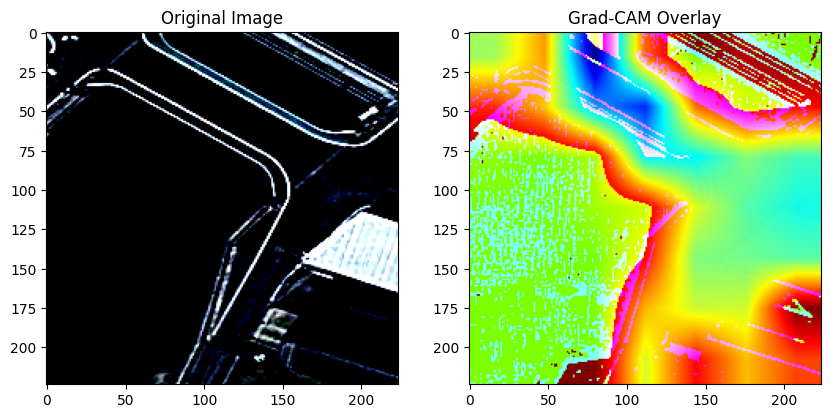

Early stopping!
Training stopped due to early stopping.


In [28]:
patience = 5
best_valid_loss = float('inf')
epochs_no_improve = 0
early_stopping = False

train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

target_layer = model.layer4[-1]
gradcam = GradCAM(model, target_layer)

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    model.eval()
    valid_loss = 0.0
    valid_correct_predictions = 0
    valid_total_predictions = 0

    with torch.no_grad():
        for valid_inputs, valid_labels in valid_loader:
            valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
            valid_outputs = model(valid_inputs)
            valid_loss += criterion(valid_outputs, valid_labels).item()

            _, valid_predicted = torch.max(valid_outputs, 1)
            valid_correct_predictions += (valid_predicted == valid_labels).sum().item()
            valid_total_predictions += valid_labels.size(0)

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = valid_correct_predictions / valid_total_predictions

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    valid_loss_list.append(valid_loss)
    valid_accuracy_list.append(valid_accuracy)

    print(f"Epoch {epoch+1}, Loss: {train_loss}, Accuracy: {train_accuracy * 100:.2f}%, "
          f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy * 100:.2f}%, "
          f"Running time: {elapsed_time}")

    sample_inputs, sample_labels = next(iter(valid_loader))
    sample_inputs = sample_inputs.to(device)
    original_image = sample_inputs[0].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    cam = gradcam.generate_cam(sample_inputs[0].unsqueeze(0))  # Generate Grad-CAM
    overlay_image = visualize_gradcam(cam, original_image)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Overlay")
    plt.imshow(overlay_image)
    plt.show()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping!")
            early_stopping = True
            break

if early_stopping:
    print("Training stopped due to early stopping.")
else:
    print("Training completed all epochs.")
